In [4]:
import json
import urllib
import os
import csv
import pandas as pd

# 0. Preliminary step to get the dataset




In [5]:
# if the filtered documents file has already been generated by previously running the notebook
# upload the file in notebook env and call it here
# run the cell that mounts google drive if you want to save output there
# then set the output folder and run the output folder cell
# after G Drive is mounted and the output folder set, go directly to step 1.3 without running the cells in between
# corpus_df = pd.read_csv('documents_list.csv')

Getting data from sharable google drive folder 

In [ ]:
# link to folder: https://drive.google.com/drive/folders/18TjiltRr8CFlx0aPcLsnKBr5iyeiQxWc?usp=sharing
# upload data folder to your drive root folder 'My Drive' (It is the default folder).

In [20]:
# connect your drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')
# after running this cell, open the url that displays below from your gmail account
# copy the code that is displayed 
# paste the code into the cell below when prompted and then press enter

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/data_tm_workflow/'

In [18]:
# set the output folder in the drive (the csv files with the results of the process will be downloaded there)
# first create the empty folder in the drive
output_folder = '/content/drive/My Drive/output_tm_mallet'

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [ ]:
files_list = os.listdir(folder_path)

In [ ]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

## 1.2. Adding columns for dates, publications and filtering dataset

### 1.2.1. dates, publications


In [ ]:
import re

In [88]:
# get publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

# get date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# get year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# get month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

# get day from file name
def get_day(file):
  month_match = re.findall(r'_\d{4}-\d{2}-(\d{2})_',file)
  return month_match[0]

In [ ]:
sources['date'] = sources['file_name'].apply(lambda x: get_date(x))
sources['year'] = sources['file_name'].apply(lambda x: get_year(x))
sources['month'] = sources['file_name'].apply(lambda x: get_month(x))
sources['day'] = sources['file_name'].apply(lambda x: get_day(x))
sources['publication'] = sources['file_name'].apply(lambda x: get_ref(x))

In [ ]:
# add publication names
def get_pub_name(pub_number):
    if (pub_number == 'sn85066408'):
        return 'L\'Italia'
    elif (pub_number == '2012271201'):
        return 'Cronaca Sovversiva'

In [ ]:
sources['publication_name'] = sources['publication'].apply(lambda x: get_pub_name(x))

### 1.2.2. Filtering

In [ ]:
import datetime
from datetime import timedelta, date

In [ ]:
# Start from 06.06.1903 and finish 01.05.1919
date_ref_1 = date(1903,6,6)
date_ref_2 = date(1919,5,1)

In [ ]:
def filter_by_date(date_item,date_ref_1,date_ref_2):
    year = re.findall(r'(\d{4})-\d{2}-\d{2}',date_item)[0]
    month = re.findall(r'\d{4}-(\d{2})-\d{2}',date_item)[0]
    day = re.findall(r'\d{4}-\d{2}-(\d{2})',date_item)[0]
    file_date = date(int(year),int(month),int(day))
    if (date_ref_1 <= file_date <= date_ref_2):
        return 'included'
    else:
        return 'not included'

In [ ]:
sources['status'] = sources['date'].apply(lambda x: filter_by_date(x,date_ref_1,date_ref_2))

In [ ]:
# variable containing the filtered documents
corpus_df = sources[sources['status'] == 'included'].copy().reset_index()

### 1.2.3 Adding text content

In [ ]:
# read the content of the text files
def readTxtContent(fileName):
  with open(folder_path + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [ ]:
# add a column to the dataframe containing file content
corpus_df['file_content'] = corpus_df['file_name'].apply(lambda x: readTxtContent(x))

In [ ]:
corpus_df.to_csv(output_folder + '/documents_list.csv')

## 1.3 Removing stop words, punctuation, short words

In [ ]:
! pip install nltk

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# add tokenized documents in dataframe
corpus_df['tokens'] = corpus_df['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [8]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to remove all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
corpus_df['doc_prep'] = corpus_df['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [ ]:
# link to custom stop words: https://drive.google.com/file/d/1VVfW6AKPbb7_fICOG73lEgkXmmZ6BkpC/view?usp=sharing
# Upload stop words list into Colab files before proceeding with the next cells

In [9]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')
en_stopwords = stopwords.words('english')

In [10]:
stop_words = pd.read_csv('stop_words.csv')

In [11]:
stopwords = stop_words['stopword'].values.tolist()

In [12]:
# add english stop words list to custom stopwords 
stopwords.extend(en_stopwords)

In [ ]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [13]:
# add column with tokenized documents without sw
corpus_df['doc_prep_nostop'] = corpus_df['doc_prep'].apply(lambda x: [w for w in x if not w in stopwords])

In [14]:
corpus_df['doc_prep_nostop']

0      [nura, dtfip, verrmo, assioma, auanto, barba, ...
1      [saturday, january, barre, vermont, sabato, ge...
2      [annj, xii, iodio, mite, umberto, santo, costi...
3      [vili, entered, brusco, svolto, storia, partit...
4      [scoi, ietti, lez, actf, àttof, coij, peri, it...
                             ...                        
766    [ionn, imperversa, giungono, spiaggie, patria,...
767    [ass, ittc, ass, tìii, eie, alt, sss, lynn, au...
768    [num, xii, magnifico, pertinacia, levato, pean...
769    [ann, rhe, fcr, rivo, ragioni, economiche, sfa...
770    [newspapet, objection, anvo, nura, mmmmmmm, an...
Name: doc_prep_nostop, Length: 771, dtype: object

In [15]:
# set the variable to use for topic modelling (if no further options are used)
corpus_model = corpus_df['doc_prep_nostop']

In [21]:
# save the data after pre-processing in the output folder for verification of pre-processing steps
# corpus_df.to_csv(output_folder + '/corpus_df.csv')
corpus_df.to_csv(output_folder + '/corpus_df.csv')

## 1.4 Lemmatize

In [ ]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [ ]:
!pip install spacy

In [ ]:
!python3 -m spacy download it_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [ ]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [ ]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [ ]:
# add column with lemmatized tokens - directly from the tokens as preprocessing has already been done
corpus_df['doc_lemmatized'] = corpus_df['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [ ]:
# variable with lemmatized tokens
lemmatized_corpus = corpus_df['doc_lemmatized']
# the lemmatized version is not used in this example

# 2. Topics with LDA Mallet

In [22]:
#Gensim installation
! pip install gensim

In [24]:
%%capture
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [25]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [26]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [27]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Creating the dictionary, optional filtering of extreme values

In [28]:
# if you use lemmatized version replace "corpus_model" by lemmatized_corpus
id2word = corpora.Dictionary(corpus_model)

In [29]:
id2word.filter_extremes(no_below=5)

### 2.1.2 Bag of words

In [30]:
corpus = [id2word.doc2bow(text) for text in corpus_model]

## 2.2 LDA

### 2.2.1. Option 1: Train a model without coherence calculation



In [31]:
# set the nr of topics
num_topics = 7

In [33]:
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [34]:
topic_print_model = model.print_topics(num_words=30)

In [35]:
df_topic_print_model = pd.DataFrame(topic_print_model, columns=['topic_id','words'])

In [36]:
df_topic_print_model.to_csv(output_folder +'/topics_without_coherence.csv')

### 2.2.2. Option 2: Train models and compute coherence

Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [37]:
from gensim.models.coherencemodel import CoherenceModel

In [38]:
# takes approx 30min to run for around 700 short documents
%%capture
topics_nr = []
coherence_values_gensim = []
models = []
models_idx = [x for x in range(3,20)]
for num_topics in range(3, 20):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
  models.append(model)
  coherencemodel = CoherenceModel(model=model, texts=corpus_model, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [39]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 3  has Coherence Value of 0.3598
Num Topics = 4  has Coherence Value of 0.3658
Num Topics = 5  has Coherence Value of 0.3977
Num Topics = 6  has Coherence Value of 0.4177
Num Topics = 7  has Coherence Value of 0.4134
Num Topics = 8  has Coherence Value of 0.4189
Num Topics = 9  has Coherence Value of 0.4236
Num Topics = 10  has Coherence Value of 0.4504
Num Topics = 11  has Coherence Value of 0.4164
Num Topics = 12  has Coherence Value of 0.441
Num Topics = 13  has Coherence Value of 0.4493
Num Topics = 14  has Coherence Value of 0.4384
Num Topics = 15  has Coherence Value of 0.4424
Num Topics = 16  has Coherence Value of 0.4453
Num Topics = 17  has Coherence Value of 0.4556
Num Topics = 18  has Coherence Value of 0.4237
Num Topics = 19  has Coherence Value of 0.4483


In [40]:
df_coherence = pd.DataFrame(topics_nr, columns=['topic_id'])

In [41]:
df_coherence['topic_coherence'] = coherence_values_gensim

In [42]:
# df_coherence.to_csv(output_folder +'/coherence_values.csv')
df_coherence.to_csv(output_folder + '/coherence_values.csv')

In [43]:
# Visualize coherence scores
import matplotlib.pyplot as plt

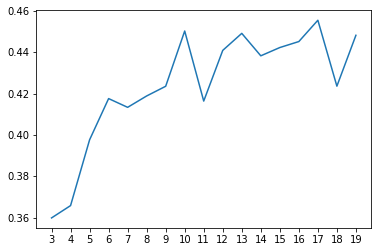

In [44]:
plt.plot(topics_nr, coherence_values_gensim)

In [45]:
# print topics for the different numbers of topics
for i in range(len(models_idx)):
  numtopics = models_idx[i]
  print('nr of topics: {}'.format(numtopics))
  model = models[i]
  topic_print = model.print_topics(num_words=30)
  df_topic_print = pd.DataFrame(topic_print, columns=['topic_id','words'])
  print(df_topic_print['words'])
  filename = '{}/num_topics_{}.csv'.format(output_folder,numtopics)
  df_topic_print.to_csv(filename)

nr of topics: 3
0    0.004*"francia" + 0.003*"italia" + 0.003*"mort...
1    0.005*"partito" + 0.005*"anarchici" + 0.004*"s...
2    0.003*"pane" + 0.003*"scioperanti" + 0.003*"do...
Name: words, dtype: object
nr of topics: 4
0    0.006*"partito" + 0.005*"socialisti" + 0.005*"...
1    0.004*"pane" + 0.003*"dinnanzi" + 0.003*"doman...
2    0.005*"polizia" + 0.004*"pubblica" + 0.003*"sc...
3    0.004*"francia" + 0.004*"pace" + 0.004*"padron...
Name: words, dtype: object
nr of topics: 5
0    0.009*"partito" + 0.009*"socialista" + 0.007*"...
1    0.006*"società" + 0.004*"dio" + 0.004*"leggi" ...
2    0.005*"pane" + 0.004*"domani" + 0.003*"nemico"...
3    0.006*"polizia" + 0.005*"scioperanti" + 0.004*...
4    0.007*"francia" + 0.005*"pace" + 0.004*"german...
Name: words, dtype: object
nr of topics: 6
0    0.005*"morte" + 0.004*"quei" + 0.004*"francia"...
1    0.004*"domani" + 0.004*"dio" + 0.004*"miseria"...
2    0.007*"società" + 0.005*"anarchico" + 0.004*"l...
3    0.010*"partito" + 0.010*"

In [46]:
# select the model to display the rest of the steps by typing the desired number of topics below
numtopics = 10

In [47]:
idx = models_idx.index(numtopics)
model = models[idx]

# Topic visualisation

In [48]:
# translate back mallet model into gensim format
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)

## Data Preparation

In [49]:
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py

--2020-07-23 14:05:58--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219774 (215K) [text/plain]
Saving to: ‘jscode-test-2.js’

jscode-test-2.js    100%[===================>] 214.62K  --.-KB/s    in 0.04s   

2020-07-23 14:05:58 (5.18 MB/s) - ‘jscode-test-2.js’ saved [219774/219774]

--2020-07-23 14:05:59--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awa

In [50]:
%%capture
!pip install funcy

In [51]:
%run -i tm1_data_prepare_gensim

<Figure size 432x288 with 0 Axes>

In [52]:
data_vis = prepare(model, corpus, id2word, doc_topic_dist=None)

In [53]:
topic_info = data_vis[1][data_vis[1]['Category'] == 'Default'].copy()

In [54]:
topic_info['relevance'] = ''

In [55]:
for i in range(numtopics):
  topic_num = i+1
  data = data_vis.sorted_terms(topic=topic_num, _lambda=.6).copy()
  topic_info = topic_info.append(data)

In [ ]:
# uncomment to show the full output of a topic, replace 'Topic8' by the topic to display
# topic_info[topic_info['Category'] == 'Topic8']

In [56]:
topic_info.to_csv(output_folder + '/topic_info.csv')

In [57]:
topic_proportion = data_vis[0].copy()

In [58]:
topic_proportion['proportion'] = topic_proportion['Freq'] / 100

In [59]:
topic_proportion.index.name = 'topic_id'

In [60]:
topic_proportion.to_csv(output_folder + '/topic_proportion.csv')

In [61]:
# download also in Jupyter environment for further processing
topic_info.to_csv('topic_info.csv')
topic_proportion.to_csv('topic_proportion.csv')

In [62]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

## Visualisation

In [63]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [64]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [65]:
%%capture
ldamodel = model

In [66]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [67]:
distribution = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [68]:
distribution.index.name = 'document'

In [69]:
# add file names and publication name
distribution_wfiles = distribution.copy()
distribution_wfiles.insert(0, 'document_path', corpus_df['file_name'])
distribution_wfiles.insert(1, 'publication_name', corpus_df['publication_name'])
distribution_wfiles

,document_path,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
document,,,,,,,,,,,,
0,2012271201_1917-08-25_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.130475,0.062306,0.060792,0.094830,0.164528,0.098493,0.075610,0.037994,0.180954,0.094018
1,2012271201_1905-01-21_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.114382,0.033278,0.153143,0.042294,0.042691,0.054291,0.124488,0.170464,0.143781,0.121187
2,2012271201_1914-08-01_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.102303,0.056200,0.169874,0.013080,0.069672,0.067892,0.071021,0.151618,0.220158,0.078183
3,2012271201_1910-04-09_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.383080,0.182649,0.018166,0.013911,0.021181,0.064453,0.145899,0.021782,0.065107,0.083772
4,2012271201_1917-10-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.020054,0.197907,0.081804,0.076682,0.388951,0.038801,0.048567,0.104731,0.021418,0.021086
...,...,...,...,...,...,...,...,...,...,...,...,...
766,2012271201_1909-03-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.372737,0.149379,0.046674,0.050078,0.052023,0.061977,0.111282,0.049684,0.040247,0.065920
767,2012271201_1917-08-04_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.039080,0.055790,0.081289,0.077458,0.173061,0.067120,0.047300,0.035752,0.319914,0.103236
768,2012271201_1914-01-17_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.023271,0.242073,0.069671,0.169041,0.130057,0.192105,0.076552,0.056552,0.025770,0.014908


## 3.2. Distribution per topic for the whole corpus

In [70]:
corpus_df['doc_length'] = corpus_df['doc_prep_nostop'].apply(lambda x: len(x))

In [71]:
topic_frequency = distribution.mul(corpus_df['doc_length'], axis=0).sum()

In [72]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [73]:
topic_proportion

topic8    12.719804
topic1    12.535909
topic4    10.859337
topic2    10.292242
topic7     9.680842
topic9     9.595497
topic3     9.095685
topic0     8.912882
topic6     8.585063
topic5     7.722739
dtype: float64

In [74]:
# dataframe with values to sort them by order of importance
distribution_df = pd.DataFrame(topic_proportion, columns=['weight'])

In [75]:
distribution_df.index.name = "topics"

In [76]:
distribution_df.to_csv(output_folder + '/topic_distribution.csv')

In [77]:
topics = distribution_df.index.array

Text(0.5, 0, 'Weight (%)')

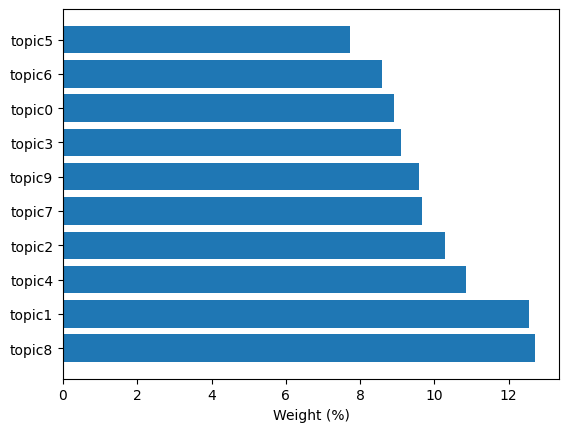

In [78]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df['weight'], align='center')
ax.set_xlabel('Weight (%)')

### 3.3. Distribution per publication


In [79]:
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [80]:
groupby2 = distribution_wfiles.copy()

In [81]:
distribution_title = groupby2.groupby(['publication_name']).mean().reset_index()
#distribution_title['publication'] = distribution_title['publication'].apply(lambda x: get_pub_name(x))

In [82]:
distribution_title

,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Cronaca Sovversiva,0.092641,0.122236,0.103222,0.087285,0.10082,0.077759,0.086045,0.094626,0.127572,0.107793


In [83]:
distribution_title.to_csv(output_folder + '/distribution_per_publication.csv')

In [84]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication_name'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

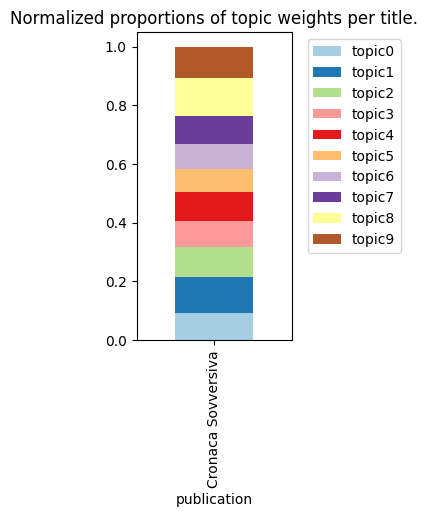

In [85]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time

## 4.1 Aggregate document weights

In [ ]:
# grouping data per month

In [89]:
distribution_wfiles['date'] = distribution_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_wfiles['year'] = distribution_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_wfiles['month'] = distribution_wfiles['document_path'].apply(lambda x: get_month(x))

In [90]:
groupby = distribution_wfiles.copy()

In [91]:
# drop columns that won't be needed at this stage
groupby = groupby.drop(['document_path', 'date'], axis=1)

In [92]:
# group by year 
distribution_year = groupby.groupby(['year']).mean().reset_index()

In [93]:
distribution_year

,year,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1903,0.070130,0.102654,0.118801,0.045565,0.043996,0.074116,0.093487,0.047500,0.112907,0.290843
1,1904,0.101225,0.103520,0.120514,0.051796,0.042779,0.083829,0.075852,0.068210,0.114210,0.238065
2,1905,0.149420,0.091662,0.107000,0.049629,0.040224,0.074335,0.081092,0.093562,0.140450,0.172627
3,1906,0.154175,0.067013,0.097217,0.043460,0.035716,0.092663,0.066877,0.098451,0.166866,0.177563
4,1907,0.103947,0.089629,0.098928,0.094151,0.044524,0.079143,0.086159,0.100264,0.136934,0.166321
5,1908,0.099753,0.103658,0.086298,0.120710,0.049492,0.073263,0.107746,0.134270,0.093279,0.131531
6,1909,0.107559,0.124412,0.128197,0.087044,0.046412,0.066374,0.138328,0.111589,0.098860,0.091226
7,1910,0.114042,0.083065,0.088474,0.087319,0.058247,0.079253,0.124348,0.150756,0.149172,0.065325
8,1911,0.099846,0.082072,0.102204,0.057783,0.066892,0.062365,0.099131,0.171588,0.192316,0.065804
9,1912,0.060000,0.134428,0.116215,0.101239,0.140342,0.081175,0.081896,0.117600,0.108008,0.059097


In [94]:
distribution_year.to_csv(output_folder + '/distribution_per_year.csv')


## 4.2 Yearly average of normalized weight per topic

### 4.2.1. Line chart view 

In [95]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_year.columns)-1
for i in range(len(distribution_year)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_year['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_year.columns[j+1]
    df_vis['distribution'].loc[x] = distribution_year.iloc[i,(j+1)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


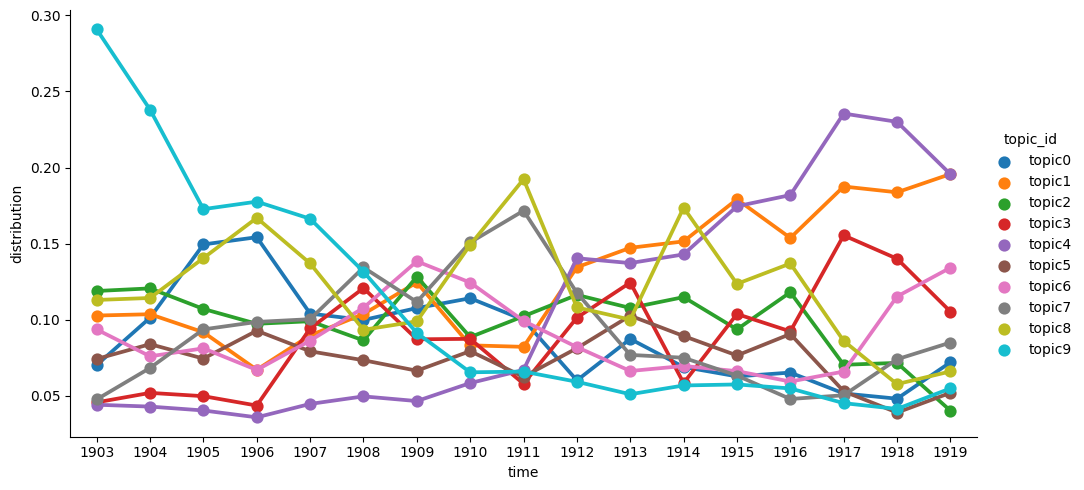

In [96]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.2. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


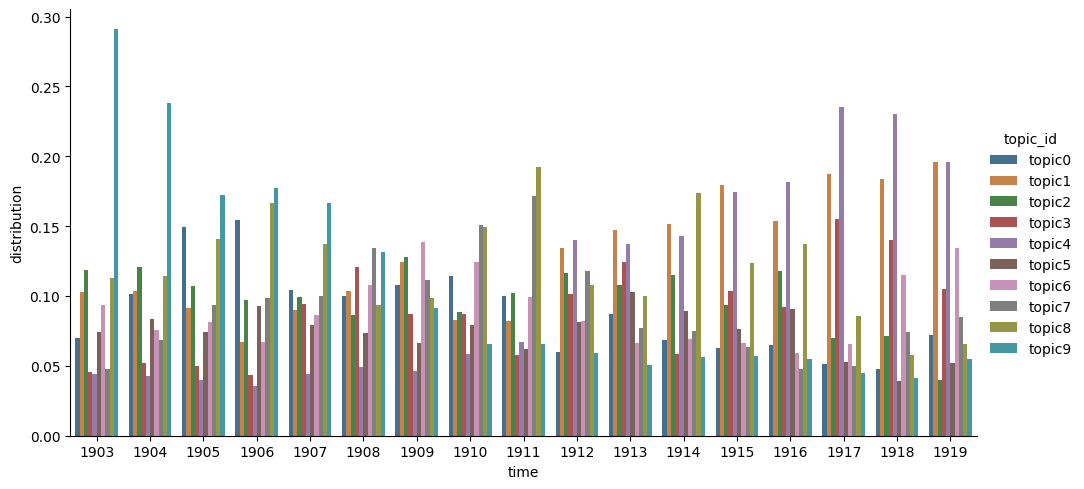

In [97]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Topic weights per title over time



In [98]:
groupby3 = distribution_wfiles.copy()

In [99]:
distribution_title_time = groupby3.groupby(['year','publication_name']).mean().reset_index()

In [100]:
distribution_title_time

,year,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1903,Cronaca Sovversiva,0.070130,0.102654,0.118801,0.045565,0.043996,0.074116,0.093487,0.047500,0.112907,0.290843
1,1904,Cronaca Sovversiva,0.101225,0.103520,0.120514,0.051796,0.042779,0.083829,0.075852,0.068210,0.114210,0.238065
2,1905,Cronaca Sovversiva,0.149420,0.091662,0.107000,0.049629,0.040224,0.074335,0.081092,0.093562,0.140450,0.172627
3,1906,Cronaca Sovversiva,0.154175,0.067013,0.097217,0.043460,0.035716,0.092663,0.066877,0.098451,0.166866,0.177563
4,1907,Cronaca Sovversiva,0.103947,0.089629,0.098928,0.094151,0.044524,0.079143,0.086159,0.100264,0.136934,0.166321
5,1908,Cronaca Sovversiva,0.099753,0.103658,0.086298,0.120710,0.049492,0.073263,0.107746,0.134270,0.093279,0.131531
6,1909,Cronaca Sovversiva,0.107559,0.124412,0.128197,0.087044,0.046412,0.066374,0.138328,0.111589,0.098860,0.091226
7,1910,Cronaca Sovversiva,0.114042,0.083065,0.088474,0.087319,0.058247,0.079253,0.124348,0.150756,0.149172,0.065325
8,1911,Cronaca Sovversiva,0.099846,0.082072,0.102204,0.057783,0.066892,0.062365,0.099131,0.171588,0.192316,0.065804
9,1912,Cronaca Sovversiva,0.060000,0.134428,0.116215,0.101239,0.140342,0.081175,0.081896,0.117600,0.108008,0.059097


In [101]:
distribution_title_time.to_csv(output_folder + 'distribution_per_publication_over_time.csv')

### 4.2.4. Rolling average

#### 4.2.4.1. Rolling average by topic

In [102]:
rolling_mean = distribution_year.rolling(2).mean()

In [103]:
rolling_mean.to_csv(output_folder + 'rolling_mean.csv')

In [104]:
#restructuring df so that it can work with seaborn
df_vis3 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean.columns)-1
for i in range(len(rolling_mean)):
  for j in range(columns_nr):
    if ( rolling_mean.iloc[i,(j+1)] > 0 ):
      df_vis3.loc[x] = ''
      df_vis3['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis3['topic_id'].loc[x] = rolling_mean.columns[j+1]
      df_vis3['rolling_mean'].loc[x] = rolling_mean.iloc[i,(j+1)]
      x+= 1

In [105]:
df_vis3

,time,topic_id,rolling_mean
0,1904,topic0,0.0856777
1,1904,topic1,0.103087
2,1904,topic2,0.119658
3,1904,topic3,0.0486804
4,1904,topic4,0.0433876
...,...,...,...
155,1919,topic5,0.0453353
156,1919,topic6,0.124641
157,1919,topic7,0.0793885
158,1919,topic8,0.0617296


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


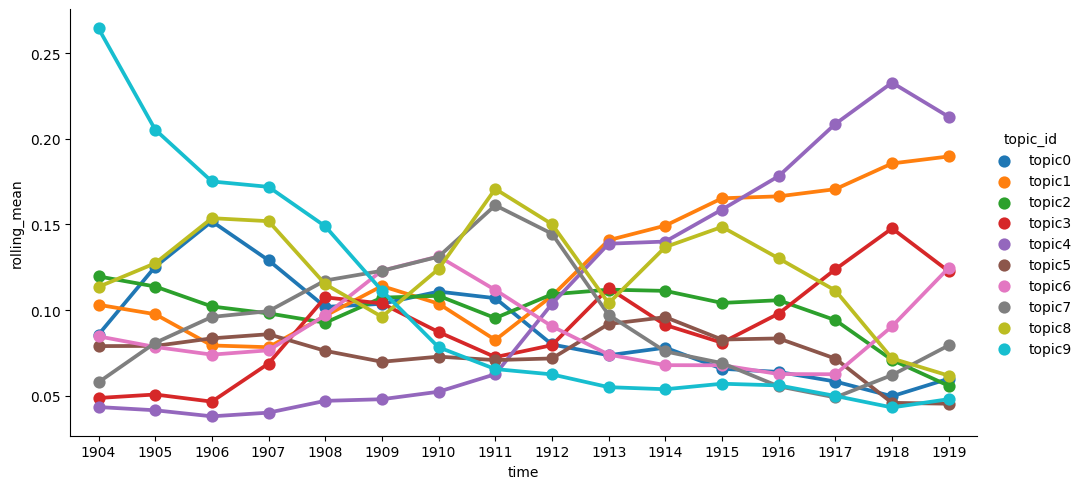

In [106]:
sns.factorplot(data= df_vis3, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

#### 4.2.4.1. Rolling average by publication

In [ ]:
# Filtering the distribution over time by publication
# in the cell below replace 'Cronaca Sovversiva' by the publication to display
# and for the output file, each time the filter is applied on a publication, change the output file name

In [107]:
distribution_publication_time = distribution_title_time[distribution_title_time['publication_name'] == 'Cronaca Sovversiva']

In [108]:
rolling_mean_publication = distribution_publication_time.rolling(2).mean()

In [109]:
rolling_mean_publication.to_csv(output_folder + 'rolling_mean_cronaca_sovversiva.csv')

In [110]:
#restructuring df so that it can work with seaborn
df_vis4 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean_publication.columns)
for i in range(len(rolling_mean_publication)):
  for j in range(columns_nr):
    if ( rolling_mean_publication.iloc[i,(j)] > 0 ):
      df_vis4.loc[x] = ''
      df_vis4['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis4['topic_id'].loc[x] = rolling_mean_publication.columns[j]
      df_vis4['rolling_mean'].loc[x] = rolling_mean_publication.iloc[i,(j)]
      x+= 1

In [111]:
df_vis4

,time,topic_id,rolling_mean
0,1904,topic0,0.0856777
1,1904,topic1,0.103087
2,1904,topic2,0.119658
3,1904,topic3,0.0486804
4,1904,topic4,0.0433876
...,...,...,...
155,1919,topic5,0.0453353
156,1919,topic6,0.124641
157,1919,topic7,0.0793885
158,1919,topic8,0.0617296


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


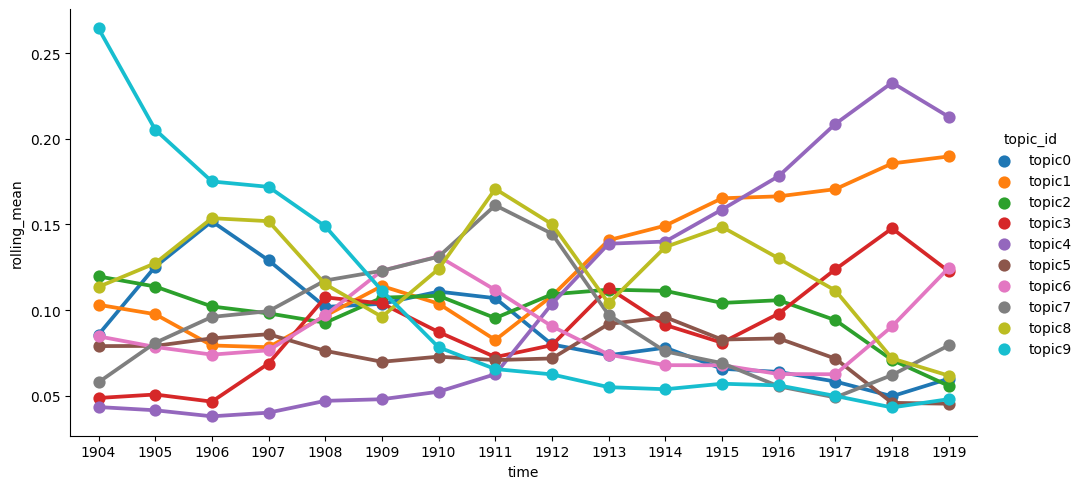

In [112]:
sns.factorplot(data= df_vis4, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)